<a href="https://colab.research.google.com/github/myoxote/spis-project/blob/main/plorbo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# imports

import numpy as np
import tensorflow as tf
from keras import datasets, layers, models, regularizers, preprocessing, applications
from keras.models import Model, Sequential
from keras.applications.resnet import ResNet50
from keras.applications.resnet import preprocess_input
from keras.preprocessing import image
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# dataset load for images

datagen = image.ImageDataGenerator()

train = datagen.flow_from_directory(
    '/content/drive/MyDrive/bingus/training',
    target_size=(1024, 1024),
    color_mode='rgb',
    classes=None,
    class_mode='binary',
    batch_size=64,
    shuffle=True,
    seed=None,
    save_to_dir=None,
    save_prefix='',
    save_format='png',
    follow_links=False,
    subset=None,
    interpolation='nearest',
    keep_aspect_ratio=False
)

Found 711 images belonging to 2 classes.


In [3]:
# making data usable for """"""training"""""""

train_datagen = image.ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/bingus/training',
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/bingus/training', # same directory as training data
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary',
    subset='validation')

Found 570 images belonging to 2 classes.
Found 141 images belonging to 2 classes.


In [4]:
#model = tf.CNN
#6 layers
#model.add(Conv2D(32,(3,3) input_shape=[250,250,3]),kernel_regulizer=tf.keras.regualizer.l1(0.0001))
#model.add(MaxPool2D(2,2))
#...repeat this 4 times -->  kernel size: odd number, make it smaller as layers go on(5,5 --> 3,3 --> 3,3 --> 3,3 --> 1,1)
# make the number of filters increase 32 --> 64 --> 128
# max_pool --> (2,2) stride=(2,2) default 1,1
# Dropout: 0.2~0.5 tk.keras.layers.Dropout()
# Flatten()
# FUlly connected layers
# tf.keras.layers.Dense(128~512,#add a regualizer if necessary)
#Dropout
#model.add(tf.keras.layers.Dense(1,activation="sigmoid/softmax"))
# model.compile()
#
# history = model.fit(EarlyStopper())

# the actual model

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3),input_shape=[64, 64, 3],activation="relu",kernel_regularizer=tf.keras.regularizers.l1(0.0001)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3),activation="relu",kernel_regularizer=tf.keras.regularizers.l1(0.0001)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128,(3,3),activation="relu",kernel_regularizer=tf.keras.regularizers.l1(0.0001)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128,(3,3),activation="relu",kernel_regularizer=tf.keras.regularizers.l1(0.0001)))
model.add(layers.MaxPooling2D(pool_size = (2, 2)))
# model.add(layers.Conv2D(16, (1, 1),kernel_regularizer=tf.keras.regularizers.l1(0.0001)))

# model.add(layers.Conv2D(64, (3, 3),kernel_regularizer=tf.keras.regularizers.l1(0.0001)))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(128, (1, 1),kernel_regularizer=tf.keras.regularizers.l1(0.0001)))



In [5]:
model.add(layers.Flatten())
model.add(layers.Dense(64,activation="relu"))

model.add(tf.keras.layers.Dense(1,activation="softmax"))
model.summary()
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
history = model.fit(train_generator, epochs=20,
                    validation_data=(validation_generator))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 128)        0

In [6]:
#Resnet Implementation: this is a different model i tried to use to fix the problem
# did not work

resnet_model = ResNet50(include_top = False, weights='imagenet',input_shape=(512,512,3))
for layer in resnet_model.layers:
  layer.trainable = False

#model
x = resnet_model.output

x = layers.GlobalAveragePooling2D()(x)
# x = tf.keras.layers.Flatten()(resnet_model.output)
x = layers.Dense(512,activation='relu',kernel_regularizer=tf.keras.regularizers.l1(0.001))(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256,activation='relu',kernel_regularizer=tf.keras.regularizers.l1(0.0001))(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128,activation='relu',kernel_regularizer=tf.keras.regularizers.l1(0.001))(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64,activation='relu',kernel_regularizer=tf.keras.regularizers.l1(0.0001))(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1,activation='softmax')(x)

model = Model(inputs = resnet_model.input, outputs = output)
#compile model
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
model.summary()
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = model.fit(train_generator,
validation_data=(validation_generator), epochs=20,batch_size=32,callbacks=[callback])

94765736/94765736 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 518, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                             

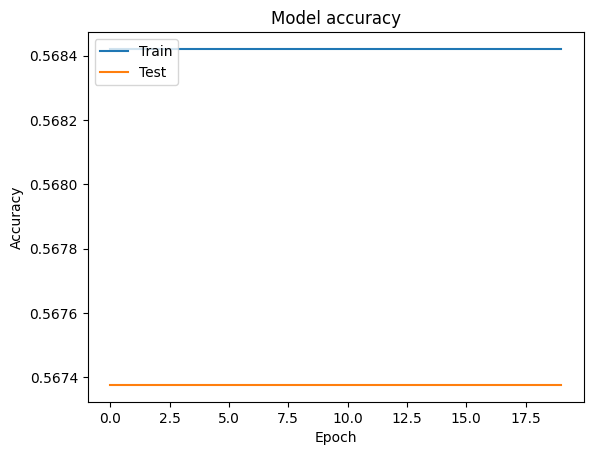

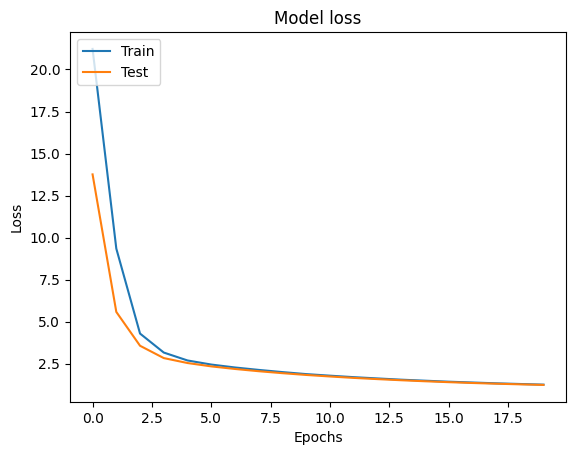

In [7]:
import matplotlib.pyplot as plt
#metrics
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

1/1 [==============================] - 0s 26ms/step
[0]
painting


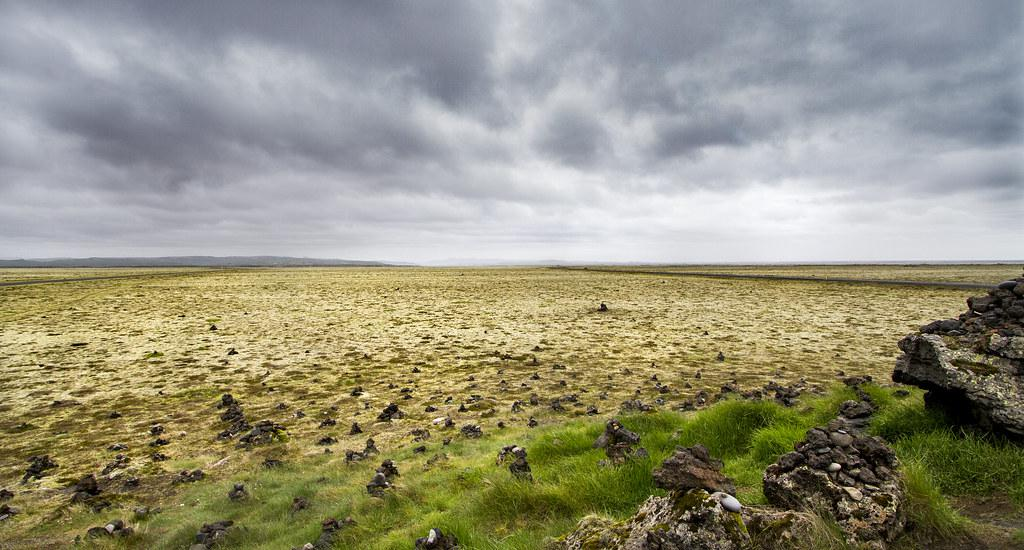

In [23]:
from IPython.display import display, Image

#actually run on image
img = tf.keras.preprocessing.image.load_img('/content/drive/MyDrive/bingus/training/photo/00000000_(6).jpg',target_size=(512,512))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.array([img_array])
# print(img_array)
prediction = model.predict(img_array)
type_data = np.argmax(prediction, axis = 1)
print(type_data)
class_names = ['painting','photo']
print(class_names[type_data.item()])
display(Image(filename='/content/drive/MyDrive/bingus/training/photo/00000000_(6).jpg'))

# /content/drive/MyDrive/bingus/training/paintings/william-james-glackens_summer-hotel-1909.jpg
# /content/drive/MyDrive/bingus/training/photo/00000000_(6).jpg
# note that it does not correctly classify the second image